In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
dtype = torch.FloatTensor

imsize = -1
PLOT = True
sigma = 25
sigma_ = sigma / 255.0

mps_device = torch.device("mps")

### movie

In [ ]:
img_all_np = np.load("../Fluo enhancement/apoptosis.npy").transpose(2, 0, 1)

img_all_np -= img_all_np.min()
img_all_np /= img_all_np.max()


# img_noisy_np = img_all_np[0:3, :, :]
# img_noisy_np -= img_noisy_np.min()
# img_noisy_np /= img_noisy_np.max()

# img_np = img_noisy_np

# plot_image_grid([img_np], 4, 5)

### single image

In [70]:
from PIL import Image

img_all_np = Image.open("../Fluo enhancement/for the paper/apoptosis_singlecell_99.tif")
img_all_np = np.array(img_all_np)
img_all_np=img_all_np[np.newaxis,:,:]
# .transpose(2, 0, 1)

img_all_np -= img_all_np.min()
img_all_np /= img_all_np.max()


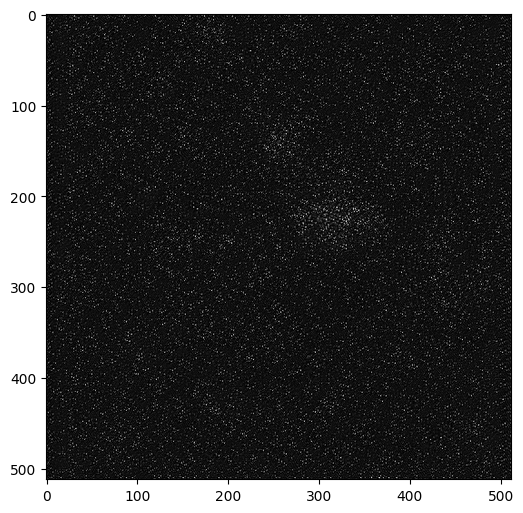

array([[[0.03095644, 0.05465578, 0.4162825 , ..., 0.07318361,
         0.08364262, 0.27866942],
        [0.0864646 , 0.04237774, 0.1403165 , ..., 0.07211979,
         0.0098249 , 0.10271714],
        [0.07521234, 0.00356072, 0.15288569, ..., 0.03202462,
         0.02414444, 0.02665603],
        ...,
        [0.10390394, 0.04812533, 0.13342781, ..., 0.11571808,
         0.05997856, 0.06619912],
        [0.02819301, 0.07787484, 0.01431322, ..., 0.0254171 ,
         0.05253984, 0.02125581],
        [0.03199931, 0.14261065, 0.15645328, ..., 0.03137907,
         0.07002857, 0.18310046]],

       [[0.03095644, 0.05465578, 0.4162825 , ..., 0.07318361,
         0.08364262, 0.27866942],
        [0.0864646 , 0.04237774, 0.1403165 , ..., 0.07211979,
         0.0098249 , 0.10271714],
        [0.07521234, 0.00356072, 0.15288569, ..., 0.03202462,
         0.02414444, 0.02665603],
        ...,
        [0.10390394, 0.04812533, 0.13342781, ..., 0.11571808,
         0.05997856, 0.06619912],
        [0.0

In [71]:
plot_image_grid([img_all_np], 4, 5)

In [72]:
INPUT = "noise"  # 'meshgrid'
pad = "reflection"
OPT_OVER = "net"  # 'net,input'

reg_noise_std = 1.0 / 30.0  # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER = "adam"  # 'LBFGS'
show_every = 99
exp_weight = 0.99

num_iter = 1000  # 2400
input_depth = 3
figsize = 5

Starting optimization with ADAM


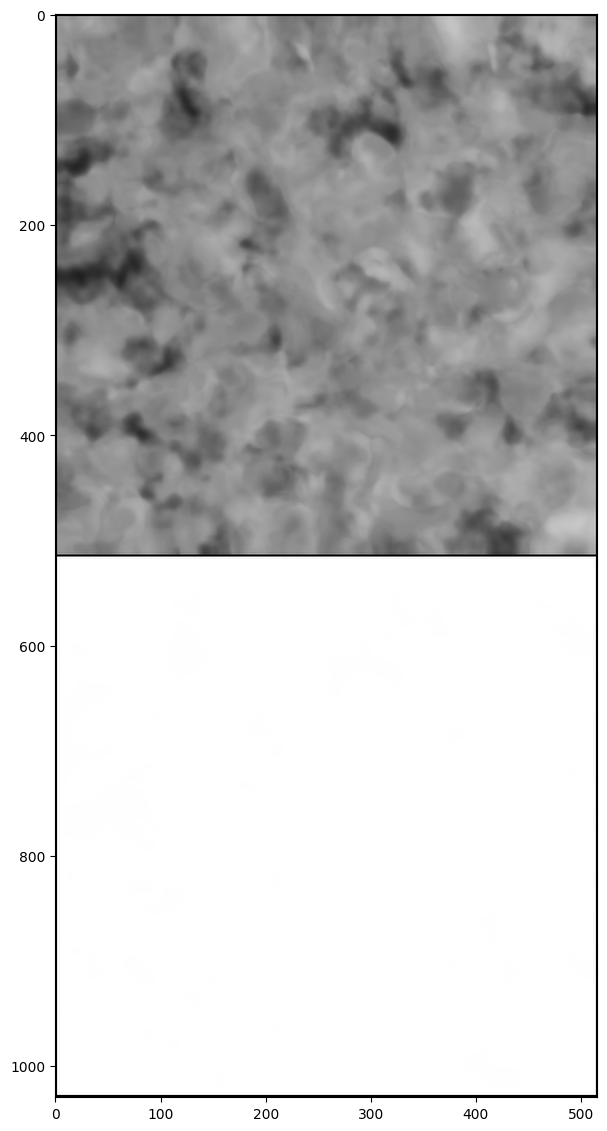

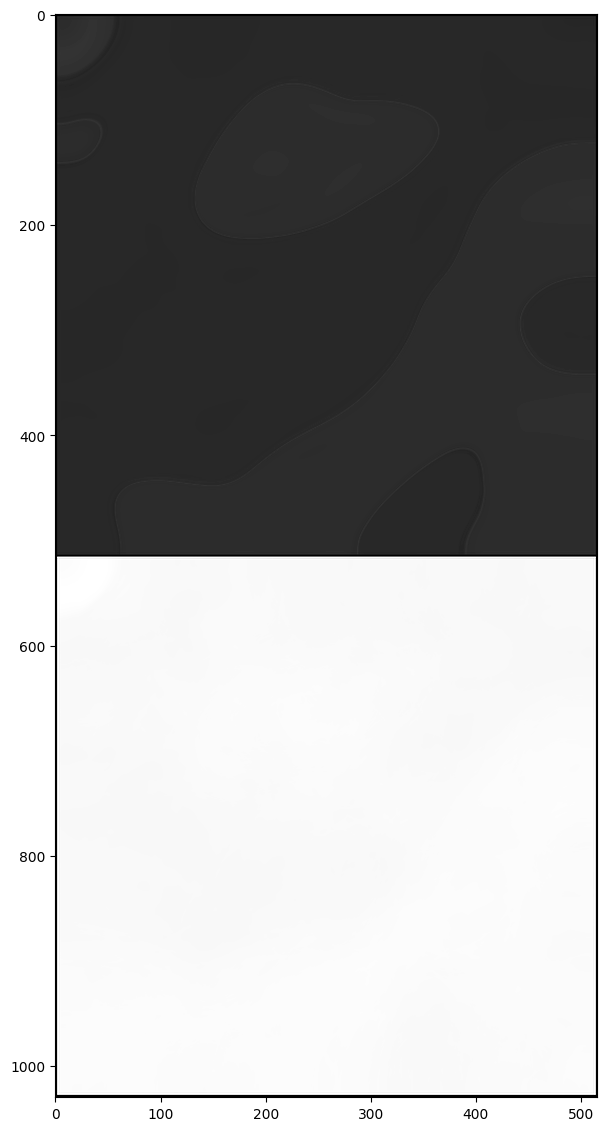

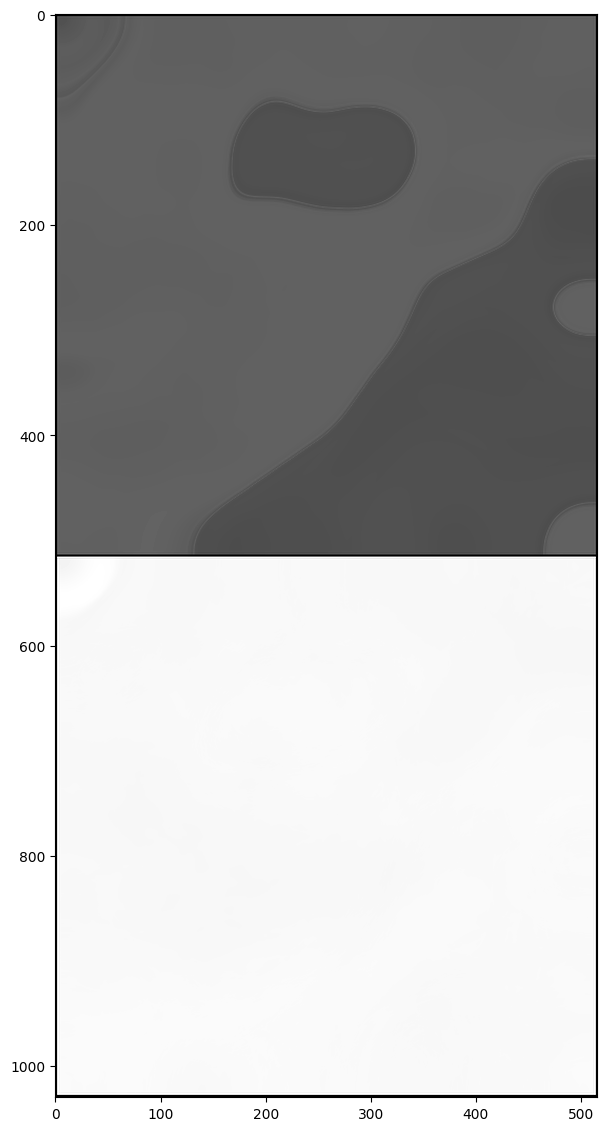

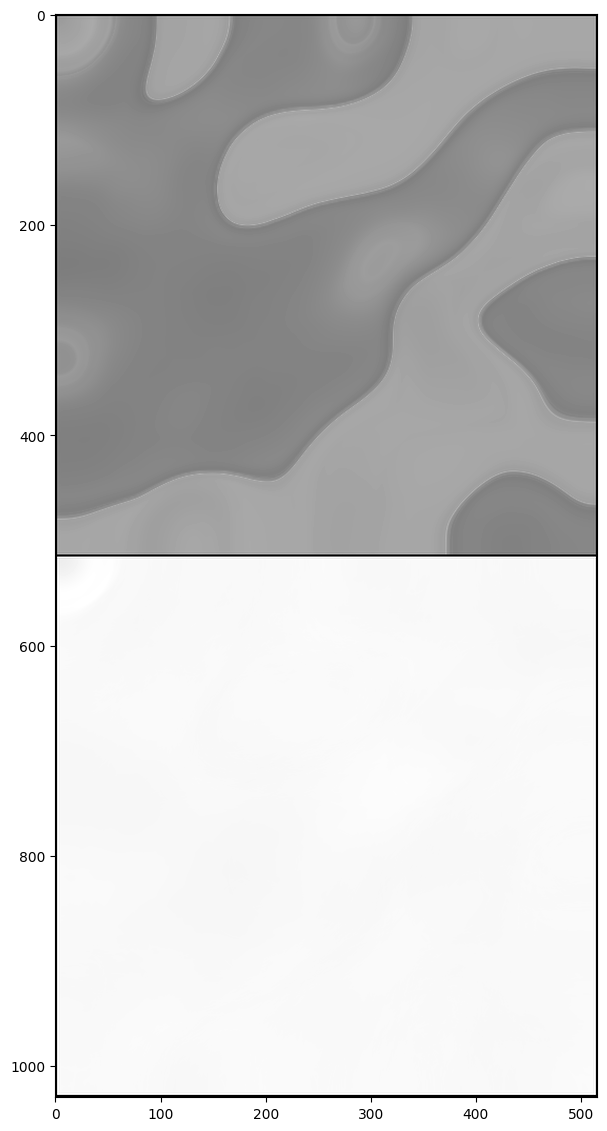

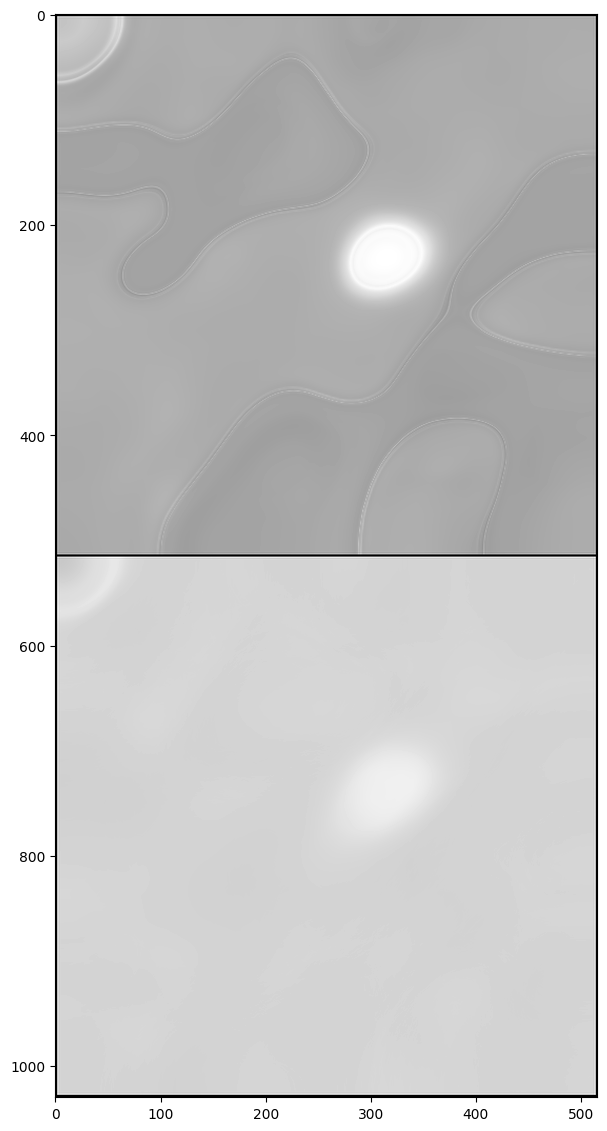

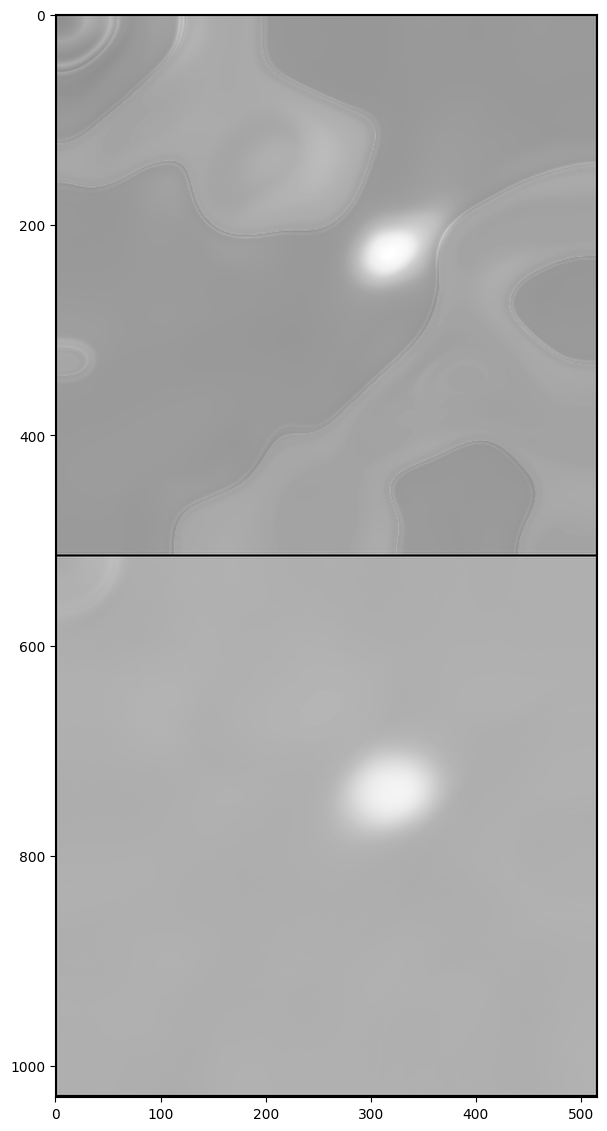

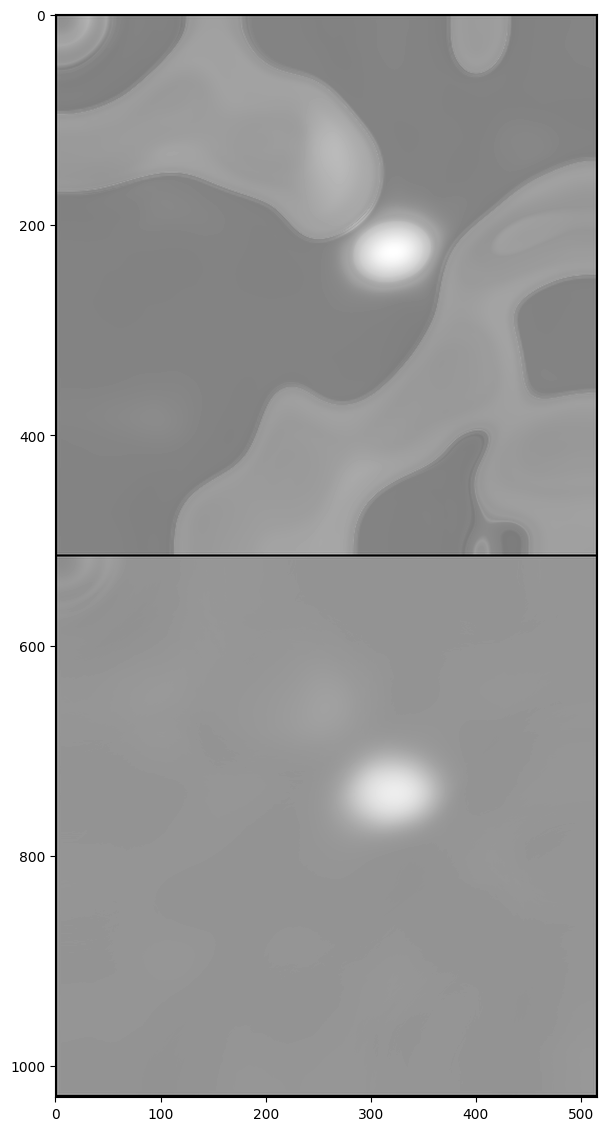

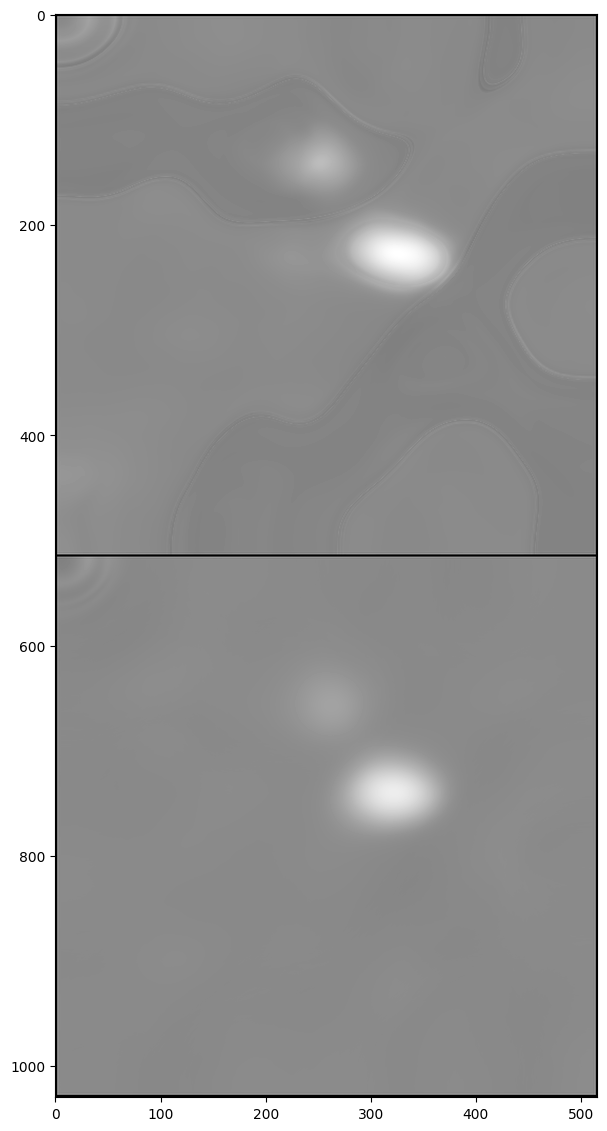

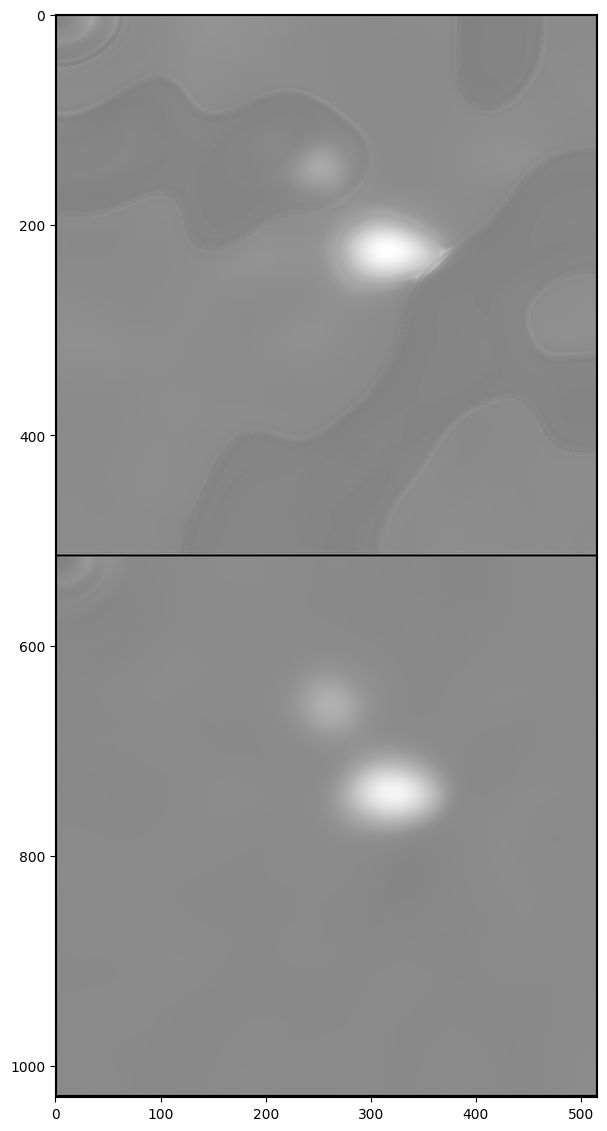

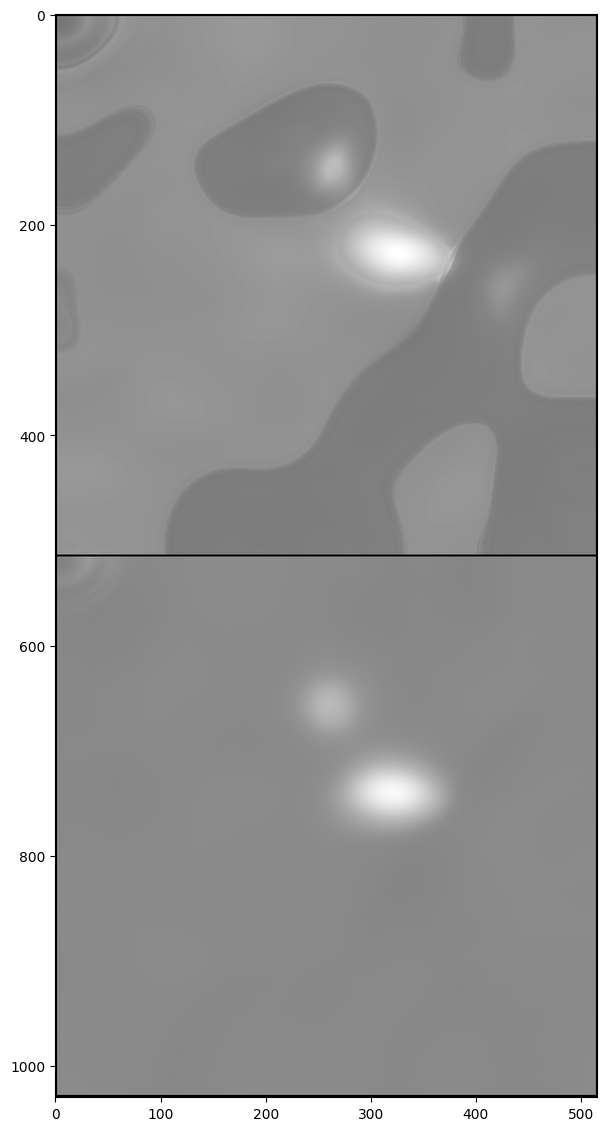

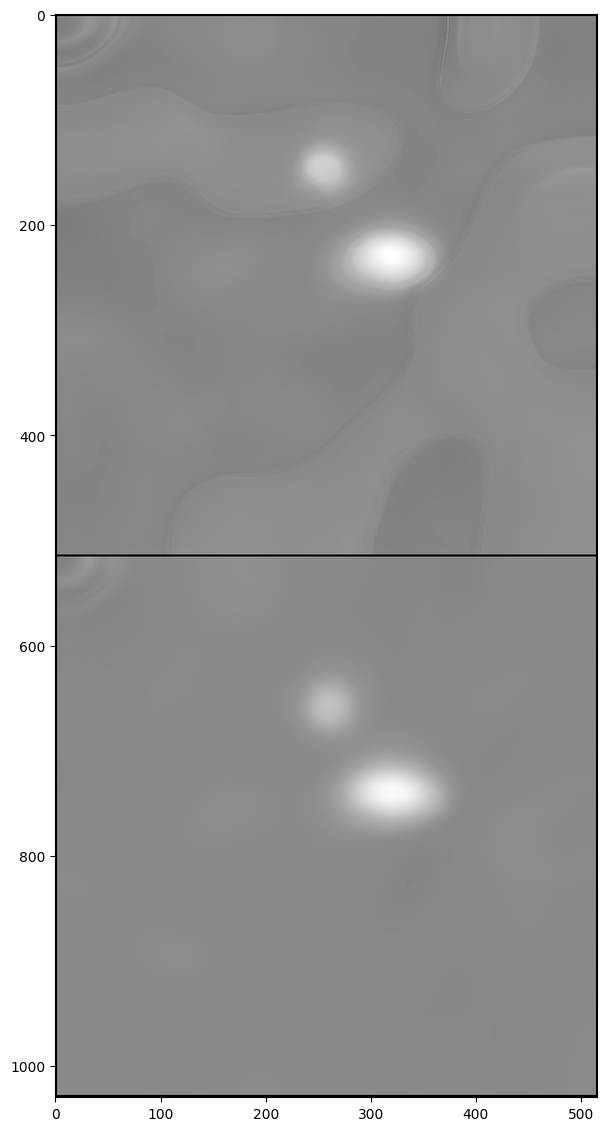

In [73]:
output_image = []

for i in range(1):

    net = skip(
        input_depth,
        1, # output
        num_channels_down=[8, 16, 32, 64, 128],
        num_channels_up=[8, 16, 32, 64, 128],
        num_channels_skip=[0, 0, 0, 4, 4],
        upsample_mode="bilinear",
        need_sigmoid=True,
        need_bias=True,
        pad=pad,
        act_fun="LeakyReLU",
    )

    net = net.type(dtype)

    # # Compute number of parameters
    # s = sum([np.prod(list(p.size())) for p in net.parameters()])
    # print("Number of params: %d" % s)

    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    # img_noisy_np = img_all_np[3 * i : 3 * i + 3, :, :]
    img_noisy_np = img_all_np
    img_np = img_noisy_np

    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

    net_input = (
        get_noise(input_depth, INPUT, (img_all_np.shape[2], img_all_np.shape[1]))
        .type(dtype)
        .detach()
    )

    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    out_avg = 1  # None
    last_net = None
    psrn_noisy_last = 0

    i = 0

    def closure():

        global i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()

        psrn_noisy = peak_signal_noise_ratio(
            img_noisy_np, out.detach().cpu().numpy()[0], data_range=1
        )
        # psrn_gt = peak_signal_noise_ratio(
        #     img_np, out.detach().cpu().numpy()[0], data_range=1
        # )
        # psrn_gt_sm = peak_signal_noise_ratio(
        #     img_np, out_avg.detach().cpu().numpy()[0], data_range=1
        # )

        # # Note that we do not have GT for the "snail" example
        # # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
        print(
            "Iteration %05d    Loss %f   PSNR_noisy: %f"
            % (i, total_loss.item(), psrn_noisy),
            "\r",
            end="",
        )
        # print(
        #     "Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f"
        #     % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),
        #     "\r",
        #     end="",
        # )
        if PLOT and i % show_every == 0:
            out_np = torch_to_np(out)
            plot_image_grid(
                [np.clip(out_np, 0, 1), np.clip(torch_to_np(out_avg), 0, 1)],
                factor=figsize,
                nrow=1,
            )

        # Backtracking
        if i % show_every:
            if psrn_noisy - psrn_noisy_last < -5:
                print("Falling back to previous checkpoint.")

                for new_param, net_param in zip(last_net, net.parameters()):
                    net_param.data.copy_(new_param.cuda())

                return total_loss * 0
            else:
                last_net = [x.detach().cpu() for x in net.parameters()]
                psrn_noisy_last = psrn_noisy

        i += 1

        return total_loss

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)

    output_image.append(net(net_input).detach().squeeze())

In [74]:
oo = torch.cat(output_image, dim=0).numpy()

(-0.5, 511.5, 511.5, -0.5)

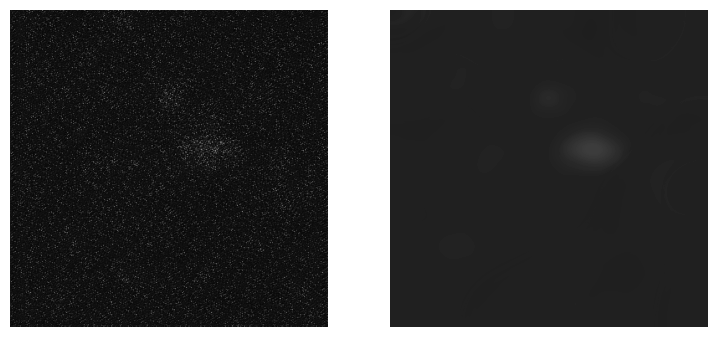

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
i=0
axes[ 0].imshow(img_all_np.squeeze(), vmin=0, vmax=1, cmap="gray")
axes[ 0].axis("off")
axes[ 1].imshow(oo.squeeze(), vmin=0, vmax=.6, cmap="gray")
axes[ 1].axis("off")

In [76]:
oo1=oo*255

image_out = Image.fromarray(oo1.astype('uint8'))  # Convert to unsigned int 8-bit for grayscale

# Specify the file path to save the TIFF file
file_path = "../Fluo enhancement/for the paper/apoptosis_singlecell_99_denoised.tif"

# Save the image as a TIFF file
image_out.save(file_path)


In [77]:
# fig, axes = plt.subplots(27, 2, figsize=(6, 61))

# for i in range(27):
#     axes[i, 0].imshow(img_all_np[i, :, :].squeeze(), vmin=0, vmax=1, cmap="gray")
#     axes[i, 0].axis("off")
#     axes[i, 1].imshow(oo[i, :, :].squeeze(), vmin=0, vmax=0.1, cmap="gray")
#     axes[i, 1].axis("off")